# Encrypted Transformers 

This notebook documents the steps involved in training and using an encrypted instance of transformers for inference. The model training is done in PyTorch, and the weights are then encrypted using VENumpy. 

In [1]:
# Import Dependencies
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, DataCollatorWithPadding, BertTokenizerFast
from transformer_medical_utils import TransformerInference, initialize_encryption_context, load_tokenizer, to_classes
import numpy as np
from tqdm.notebook import tqdm
from venumML.venumpy import small_glwe as vp
import pandas as pd
# import math
import random

from venumML.deep_learning.transformer.transformer import *
from venumML.venum_tools import *
from venumML.approx_functions import *

# Scenario 

## Healthcare rhymes with Privacy

One of the key challenges in healthcare is that critical information is often stored as unstructured text such as medical charts. A further challenge is that, given the sensitivity of this data, the insights of healthcare providers are isolated from each other. Encrypted ML allows for the creation of a network of healthcare providers, safely pooling encrypted medical chart data, and massively boosting the training of an encrypted transformer through frameworks such as federated learning.
‍
This is a critical solution for areas such as rare-disease classification. In the following example, we will take a look at the intake chart of a (not real) patient with Wilson’s disease (a genetic disorder that affects the brain and liver).

## Business case we're implementing

A large healthcare provider handles sensitive patient information, including medical histories, lab results, and diagnostic reports. To support clinicians, they use a machine learning model to analyze complex medical records and suggest possible diagnoses for rare diseases based on symptom descriptions and lab results.

## Privacy Concerns:

Due to the sensitive nature of patient data, privacy and confidentiality are critical. Unauthorized access to this data could lead to severe legal repercussions and potential harm to patient trust. Any diagnostic tool must ensure the data remains encrypted, even during processing, to protect against both internal and external security threats.

## Challenge:

The healthcare provider needs a diagnostic assistance model capable of processing encrypted medical data to provide accurate diagnosis suggestions while maintaining full data confidentiality.

## Solution:

Utilize an encrypted transformer-based model with the following capabilities:

- Data Encryption: Employ advanced encryption methods, like homomorphic encryption, allowing the model to operate on encrypted data directly.
- Secure Inference: Implement transformer-based model architecture (e.g., BERT) on encrypted data, ensuring predictions and intermediate computations remain confidential.
- High Accuracy in Diagnostics: Leverage transformer models to capture complex language patterns in medical records for accurate diagnosis, even with the data encrypted.
- Regulatory Compliance: Ensure that all model operations comply with healthcare data protection laws by keeping all personal health information encrypted during processing.


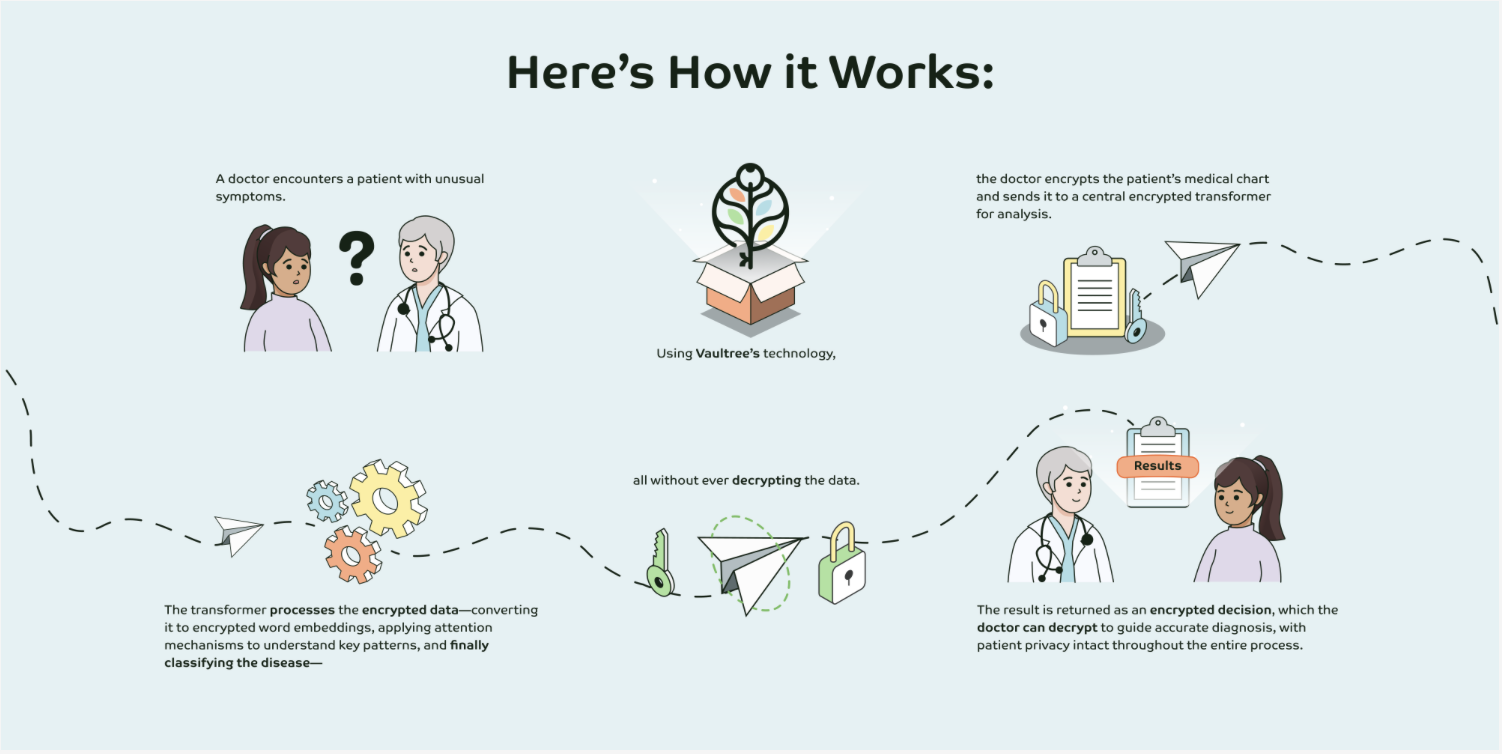

## The Data

Let's start by importing data we've generated with ChatGPT. The data is simulating a medical record such as the one below:

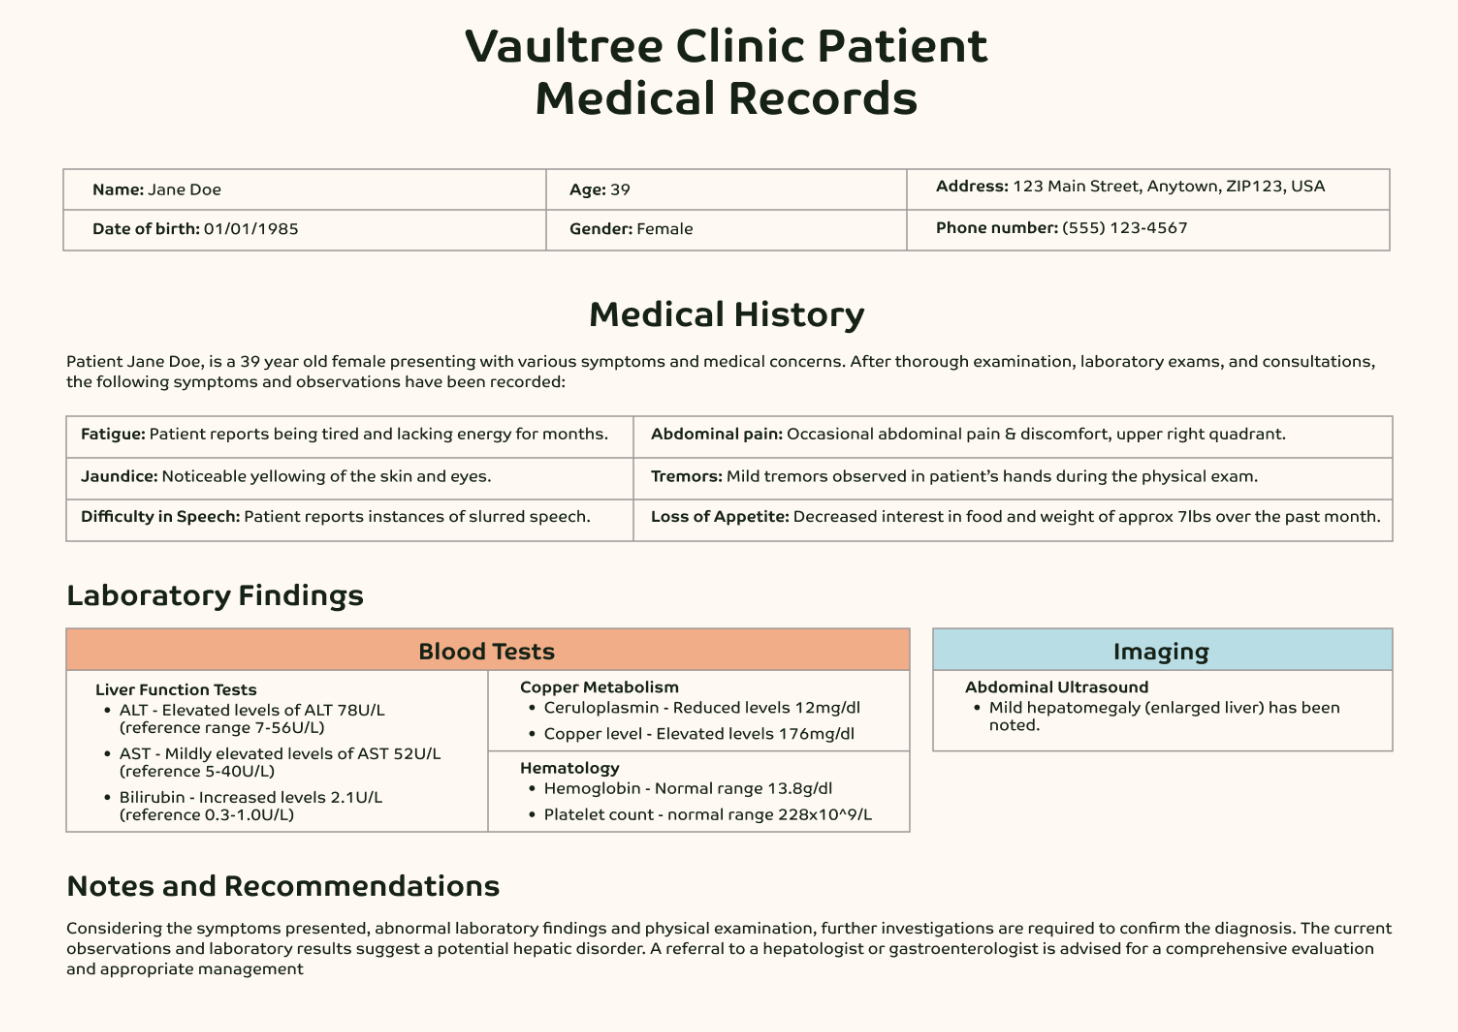

In [2]:
# Import the transformer data folder
data_folder = "../use_cases/transformer_demo/data/"
data = pd.read_csv(data_folder + "chatgpt_medical_reports_rare_diseases.csv",encoding='utf-8',index_col=False)

data.columns = ['idx','condition', 'text']
label_mapping = dict(zip(data.condition.unique(),range(data.condition.nunique())))
data['label'] = data['condition'].map(label_mapping)

In [3]:
# Reverse the dictionary
reversed_label_mapping = {value: key for key, value in label_mapping.items()}

## Instantiate encrypted context 
Let's start by setting up our context.

In [4]:
ctx = initialize_encryption_context()


## Load weights from pre-trained model

In this step, we load the weights from the pre-trained model and then encrypt them using VENumpy and `venum_tools` `encrypt_array` method.

In [5]:
model_path = "../use_cases/transformer_demo/model/"


## Encrypted Transformer Class
The encrypted weights (`encrypted_state_dict`) are passed as an argument to the Encrypted Transformer Class (`TransformerModule`) along with the hyperparameters listed previously.

In [6]:
tokenizer = load_tokenizer()

transformer = TransformerInference(
    model_weights_path=model_path+"/medical_2heads.pth",
    tokenizer=tokenizer,
    encryption_context=ctx,
    max_seq_len=20,
    d_model=8,
    num_heads=2,
    d_ff=32,
    vocab_size=30522,  # Example vocab size
    class_size=len(label_mapping)
)



Encrypting weights:   5%|▍         | 1/21 [00:07<02:35,  7.80s/it]/Users/cathal.smyth/Desktop/github/ML/venumML_internal/demos/use_cases/transformer_medical_utils.py:44: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  weight = state_dict[k].T.numpy()
Encrypting weights: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


## Inference Text
Create the prompt listing of symptoms used to perform the final diagnosis, then encrypt it.

In [7]:
texts = ["Liver Function Tests (LFTs): Results indicating liver dysfunction (AST, ALT, Bilirubin elevated)"]
output_linear = transformer.predict(texts)
print(output_linear)

[[<venumML.venumpy.small_glwe.Ciphertext object at 0x2da9e0f40>


## Decryption
Decrypt the output of the encrypted transformer

In [8]:
output = ([[i.decrypt() for i in batch] for batch in output_linear])

## Predicted Disease in Plaintext
Finally, we print out the predicted class of the supplied list of symptoms based on the highest probability from the softmax output.

In [ ]:
probabilities, predicted_class_idx = to_classes(output)
predicted_class = reversed_label_mapping[predicted_class_idx[0]]
print(predicted_class)

Wilson's Disease
